In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from numpy.random import rand
import pandas as pd
import copy
import tqdm

from simulation_functions import run_simulation

In [2]:
elements = 10000

rand_FWHM = (rand(elements) * 3) + 3
rand_radius = (rand(elements) * 6) + 7
rand_A = (rand(elements) * 40)

data = run_simulation(rand_FWHM, rand_radius, rand_A, mp_processes = 8)

Simulating 10000 points
Launching 8 threads 



100%|██████████| 10000/10000 [03:05<00:00, 53.90it/s]



All threads completed! Total time: 0 h, 3 min, 11 s


In [3]:
data.head()

,FWHM,volume,volume2area,A_est,A_true,analytical,b_x,b_nx,b_y,b_ny,b_z,b_nz
0,3.937520,2824,2.914345,30.517412,39.064052,30.122529,0.131517,0.100371,0.110664,0.121224,0.125169,0.106719
1,5.056348,1085,2.205285,14.206400,22.538607,13.783697,0.068592,0.051822,0.060078,0.060336,0.064413,0.056000
2,3.896239,1032,2.106122,3.928693,5.650104,3.879299,0.017203,0.005347,0.007733,0.014818,0.012377,0.010174
3,4.167467,2618,2.833333,8.234615,10.795477,8.105375,0.040885,0.027202,0.030516,0.037572,0.036980,0.031107
4,3.976425,3505,3.066492,14.516181,18.311184,14.288464,0.070042,0.048949,0.055536,0.063455,0.061447,0.057544


In [4]:
data.describe()

,FWHM,volume,volume2area,A_est,A_true,analytical,b_x,b_nx,b_y,b_ny,b_z,b_nz
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.500974,2203.010000,2.643733,14.194019,19.724819,13.888009,0.078454,0.040310,0.047857,0.070906,0.063467,0.055297
std,0.867314,1019.930212,0.408270,8.429020,11.516105,8.293993,0.050074,0.028131,0.031807,0.045297,0.040524,0.035724
min,3.000011,746.000000,1.825776,0.000451,0.000764,0.000422,0.000003,0.000001,0.000002,0.000002,0.000002,0.000002
25%,3.749253,1280.500000,2.282629,7.015513,9.790228,6.835153,0.037055,0.017540,0.021880,0.033157,0.029870,0.025833
50%,4.517685,2026.500000,2.640762,13.950204,19.604336,13.555993,0.074132,0.035615,0.043842,0.066800,0.059764,0.051776
75%,5.243966,3001.250000,2.993076,21.083639,29.767850,20.575510,0.112812,0.058391,0.069255,0.102593,0.091966,0.080202
max,5.999708,4384.000000,3.578472,33.676181,39.995337,33.647523,0.249674,0.163237,0.180689,0.218749,0.197276,0.174805


## DNN Model
### Data preparation
The data is divided up into training and test sets. The labels, *A_true*, is removed from the parameter data. The dataframes are transformed into tensors to be compatible with pytorch.

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim


df_train = data.dropna().sample(frac=0.8, random_state=0)
df_test = data.dropna().drop(df_train.index)

train_labels = df_train.pop("A_true")
test_labels = df_test.pop("A_true")

In [6]:
x_train = torch.tensor(df_train.to_numpy(), dtype=torch.float32)
y_train = torch.tensor(train_labels.to_numpy(),dtype=torch.float32).reshape(-1, 1)

x_test = torch.tensor(df_test.to_numpy(), dtype=torch.float32)
y_test = torch.tensor(test_labels.to_numpy(),dtype=torch.float32).reshape(-1, 1)

input_features = x_train.shape[1]
print(x_train.shape, y_train.shape)

torch.Size([8000, 11]) torch.Size([8000, 1])


### Defining the network
nn.Sequential defines a simple network. *Linear* is a standard fully connected DNN layer and *ReLU* is the rectified linear unit function (0 if x < 0 else x).

*L1Loss*: mean absolute error

*Adam*: Adaptive moment estimation. *lr*: Learning rate, factor determining how large the change to the new weights is each epoch.

Batch size is the number of features passed through the model and the loss averaged before the model is updated.

In [9]:
model = nn.Sequential(
    nn.Linear(input_features, 32),
    nn.ReLU(),
    # nn.Linear(64, 64),
    # nn.ReLU(),
    nn.Linear(32, 64),
    nn.ReLU(),
    nn.Linear(64, 1)
)

# loss function and optimizer
loss_fn = nn.MSELoss() #nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_epochs = 200   # number of epochs to run
batch_size = 10  # size of each batch

In [10]:
batch_start = torch.arange(0, len(x_train), batch_size)

# Hold the best model
best_error = np.inf   # init to infinity
best_weights = None
history = []
loss_history = []
 
for epoch in tqdm.trange(n_epochs, disable = False, unit="epochs"):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description("Epoch {:>3}".format(epoch))
        for start in bar:
            # take a batch
            X_batch = x_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad() # Reset gradient
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(error=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(x_test)
    error = loss_fn(y_pred, y_test)
    error = float(error)
    history.append(error)
    if error < best_error:
        best_error = error
        best_weights = copy.deepcopy(model.state_dict())

100%|██████████| 200/200 [01:51<00:00,  1.79epochs/s]


Best Error: 0.0204


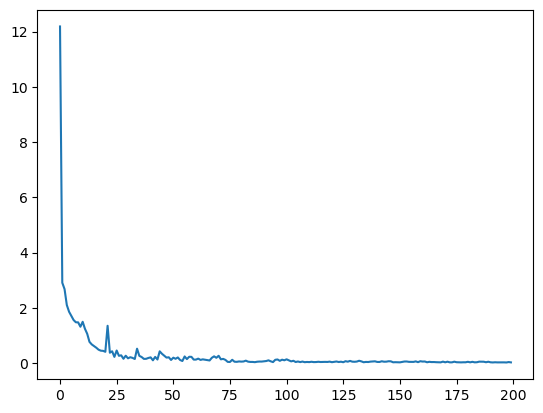

In [11]:
# restore model and return best accuracy
model.load_state_dict(best_weights)
print("Best Error: %.4f" % best_error)
plt.plot(history)
plt.show()

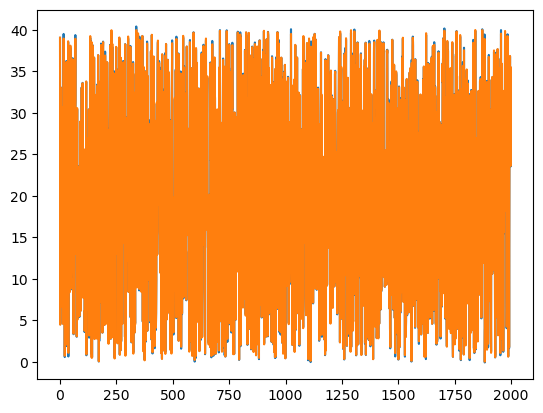

In [12]:
model.eval()
prediction = model(x_test)

with torch.no_grad():
    plt.plot(range(len(prediction.reshape(-1))), prediction)
    plt.plot(range(len(prediction.reshape(-1))), y_test)

## Verification

To check how well the model handels unknown data new data is generated and the parameters are used to predict the true activity.

In [13]:
elements = 500

ver_rand_FWHM = (rand(elements) * 3) + 3
ver_rand_radius = (rand(elements) * 6) + 7
ver_rand_A = (rand(elements) * 40)

ver_data = run_simulation(ver_rand_FWHM, ver_rand_radius, ver_rand_A, mp_processes = 2)

Simulating 500 points
Launching 2 threads 



100%|██████████| 500/500 [00:09<00:00, 52.84it/s] 



All threads completed! Total time: 0 h, 0 min, 23 s


tensor(0.1035)


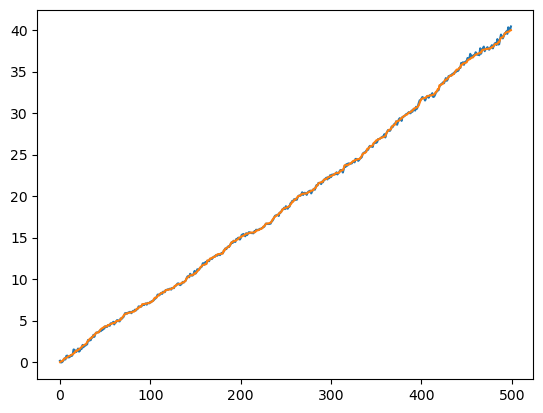

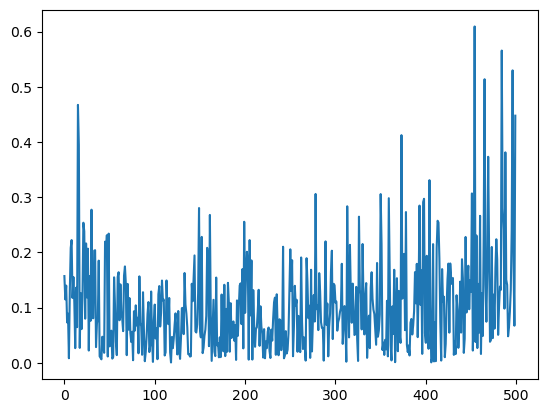

In [14]:
ver_data.sort_values(by="A_true", inplace=True)
ver_labels = ver_data.pop("A_true")

ver_x = torch.tensor(ver_data.to_numpy(), dtype=torch.float32)
ver_y = torch.tensor(ver_labels.to_numpy(),dtype=torch.float32).reshape(-1, 1)

model.eval()
prediction = model(ver_x)



with torch.no_grad():
    print(torch.mean(torch.abs(ver_y - prediction)))
    
    plt.plot(range(len(prediction.reshape(-1))), prediction)
    plt.plot(range(len(prediction.reshape(-1))), ver_y)
    
    plt.figure()
    plt.plot(range(len(prediction.reshape(-1))), torch.abs(ver_y - prediction))